# Data Evaluation for Multi-Grasp motion planner

In [56]:
# Common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Profiling
This section contains code to load, average and visualize profiling results.

In [2]:
    def load_stats(filename):
        """Load profiling stats for an algorithm from the given file.
        Args:
            filename, string: name of the stats file.
        Returns:
            pd.DataFrame: Profiling stats with standard deviations
        """
        run_stats = pd.read_csv(filename)
        avg_run_stats = run_stats.groupby('function_name').mean()
        time_columns = ['total_runtime', 'avg_runtime', 'total_cpu_time', 'avg_cpu_time']
        time_columns_std = [name + "_std" for name in time_columns]
        avg_run_stats[time_columns_std] = run_stats.groupby('function_name').std()[time_columns]
        return avg_run_stats

Show the profiling stats of a specific algorithm:

In [6]:
load_stats('/tmp/test/LazySP_LWLPAstar__LazyWeightedMultiGraspGraph__Bugtrap2DScene__4/run_stats')

,num_calls,total_runtime,avg_runtime,total_cpu_time,avg_cpu_time,total_runtime_std,avg_runtime_std,total_cpu_time_std,avg_cpu_time_std
function_name,,,,,,,,,
IntegralEdgeCostComputer::lowerBound,125308.000000,0.028831,2.300803e-07,0.031029,2.476193e-07,3.081851e-04,2.459481e-09,0.000265,2.112158e-09
LPAStarAlgorithm::computeShortestPath,24.000000,1.498477,6.243647e-02,1.498170,6.242387e-02,1.275449e-02,5.313933e-04,0.012734,5.306293e-04
LPAStarAlgorithm::updateEdges,24.000000,0.000078,3.245363e-06,0.000080,3.319443e-06,4.494778e-07,1.872800e-08,0.000002,9.622697e-08
MultiGraspRoadmapGraph::checkValidity,28394.000000,0.294175,1.036051e-05,0.294844,1.038401e-05,1.610155e-02,5.671087e-07,0.016084,5.664405e-07
MultiGraspRoadmapGraph::getEdgeCost,548399.000000,0.931123,1.697897e-06,0.941850,1.717457e-06,1.224284e-02,2.232431e-08,0.012308,2.243943e-08
MultiGraspRoadmapGraph::getEdgeCostWithGrasp,104.000000,0.011566,1.112150e-04,0.011564,1.111923e-04,1.514402e-04,1.456296e-06,0.000154,1.481468e-06
MultiGraspRoadmapGraph::getGoalCost,42.000000,0.000016,3.756350e-07,0.000017,4.126983e-07,2.579406e-07,6.141066e-09,0.000004,9.014114e-08
MultiGraspRoadmapGraph::getSuccessors,11447.000000,0.085236,7.446137e-06,0.085394,7.459947e-06,1.242486e-03,1.085428e-07,0.001272,1.111358e-07
MultiGraspRoadmapGraph::heuristic,11291.000000,0.004434,3.926933e-07,0.004514,3.997580e-07,4.123267e-05,3.652202e-09,0.000082,7.273724e-09


## Loading summarized results
This section contains code to load summarized results, i.e. number of evaluated nodes, runtime, number of evaluated edges, ...

In [3]:
algo_to_function = {
    "LazySP_LWLPAstar": 'lazySP',
    "LazySP_LLPAstar": 'lazySP',
    "LazySP_LPAstar": 'lazySP',
    "LWAstar": "lwaStarSearch",
    "LWLPAstar": "lpaStarSearch",
    "LPAstar": "lpaStarSearch",
    "Astar": "aStarSearch",
    # TODO add other algorithm to function mappings here
}

def count_event(log_line, storage):
    """ Count a roadmap evalation log event.
    Args:
        log_line, str - a line from a log file.
        storage, dict - dictionary to update counts in.
            Needs to have keys 'base_validity', 'grasp_validity', 'base_cost', 'grasp_cost', 'base_expansions'. 'grasp_expansions'
    """
    line_args = log_line.split(',')
    storage['base_validity'] += line_args[0] == "VAL_BASE"
    storage['grasp_validity'] += line_args[0] == "VAL_GRASP"
    storage['base_cost'] += line_args[0] == "EDGE_COST"
    storage['grasp_cost'] += line_args[0] == "EDGE_COST_GRASP"
    storage['base_expansions'] += line_args[0] == "BASE_EXPANSION"
    storage['grasp_expansions'] += line_args[0] == "EXPANSION"

def load_test_case_result(result_folder, runtime_type='total_runtime'):
    """Load the result of a single test case and return it as a pandas.Series.
    Args:
        result_folder, string: The folder containing the results of the test case.
            The folder should contain four files 'log_evaluation', 'log_roadmap', 'run_stats' and 'results' produced
            by testing the MGSearchMotionPlanner. The name of the result folder should follow the format
            <algo_name>__<graph_name>__<scene_name>__<num_grasps>
    """
    folder_name = os.path.basename(os.path.normpath(result_folder))
    algo_name, graph_name, scene_name, num_grasps = folder_name.split('__')
    num_grasps = int(num_grasps)
    # load runtime statistics
    avg_run_stats = load_stats(result_folder + '/run_stats')
    # read number of roadmap nodes
    with open(result_folder + '/log_roadmap', 'r') as roadmap_file:
        num_nodes = len(roadmap_file.readlines())
    # read number of validity checks, edge evaluations and expansions
    roadmap_evaluations = {'base_validity': 0, 'grasp_validity': 0, 'base_cost': 0, 'grasp_cost': 0, 'base_expansions': 0, 'grasp_expansions': 0}
    with open(result_folder + '/log_evaluation', 'r') as evalulation_file:
        for line in evalulation_file:
            count_event(line, roadmap_evaluations)
    # read planning results
    planning_results = pd.read_csv(result_folder + '/results')
    # perform sanity checks
    uniqueness = planning_results.nunique()
    if uniqueness[uniqueness != 1].size > 0:
        raise ValueError("ERROR: The results in folder %s are inconsistent:\n %s" % (result_folder, str(planning_results)))
    # Create Series for this test case
    return pd.Series({'algorithm': algo_name, 
                      'graph': graph_name, 
                      'runtime': avg_run_stats.loc[algo_to_function[algo_name], runtime_type],
                      'runtime_std': avg_run_stats.loc[algo_to_function[algo_name], runtime_type + '_std'], 
                      'base_validity_checks': roadmap_evaluations['base_validity'],
                      'grasp_validity_checks': roadmap_evaluations['grasp_validity'],
                      'base_edge_cost': roadmap_evaluations['base_cost'],
                      'grasp_edge_cost': roadmap_evaluations['grasp_cost'],
                      'base_expansions': roadmap_evaluations['base_expansions'],
                      'grasp_expansions': roadmap_evaluations['grasp_expansions'],
                      'roadmap_size': num_nodes,
                      'scene': scene_name, 
                      'num_grasps': num_grasps,
                      'cost': planning_results['cost'].iloc[0],
                      'goal_id': planning_results['goal_id'].iloc[0]})

def load_results(results_base_folder):
    """Load all results in the given base folder and return in a single DataFrame.
    Args:
        results_base_folder, str: Path to the folder containing various result sub-folders.
    Returns:
        pd.DataFrame: Data frame containing all results.
    """
    series = []
    for fname in os.listdir(results_base_folder):
        series.append(load_test_case_result(results_base_folder + '/' + fname))
    return pd.DataFrame(series)

In [5]:
data = load_results('/home/joshua/projects/placement_catkin/experiment_results')
data.sort_values(['scene', 'algorithm'])
# pr = pd.read_csv('/tmp/test/LazySP_LWLPAstar__LazyWeightedMultiGraspGraph__Bugtrap2DScene__4/results')
# pr['cost'].iloc[0]

,algorithm,graph,runtime,runtime_std,base_validity_checks,grasp_validity_checks,base_edge_cost,grasp_edge_cost,base_expansions,grasp_expansions,roadmap_size,scene,num_grasps,cost,goal_id
10,Astar,SingleGraspGraph,26.879280,0.068834,5237,9374,0,181779,0,6998,10006,Bugtrap2DScene,4,1140.12000,1
22,Astar,MultiGraspGraph,25.336720,0.387279,4777,8446,0,170031,1,6544,10006,Bugtrap2DScene,4,1140.12000,1
43,LPAstar,MultiGraspGraph,26.263800,0.336412,4777,8446,0,170031,1,6544,10006,Bugtrap2DScene,4,1140.12000,1
48,LPAstar,SingleGraspGraph,26.374060,0.429831,5237,9374,0,181779,0,6998,10006,Bugtrap2DScene,4,1140.12000,1
0,LWAstar,FoldedMultiGraspGraphStationary,1.985256,0.045848,5978,2458,4146,2343,4123,2308,10006,Bugtrap2DScene,4,1140.12000,1
4,LWAstar,MultiGraspGraph,1.737768,0.048365,3940,7088,0,6584,1,6544,10006,Bugtrap2DScene,4,1140.12000,1
13,LWAstar,FoldedMultiGraspGraphDynamic,1.776600,0.032136,5280,1537,4146,1450,4123,1436,10006,Bugtrap2DScene,4,1140.12000,1
40,LWAstar,SingleGraspGraph,1.794670,0.022894,4206,7597,0,7053,0,6998,10006,Bugtrap2DScene,4,1140.12000,1
2,LWLPAstar,SingleGraspGraph,1.670298,0.047618,4206,7597,0,7053,0,7053,10006,Bugtrap2DScene,4,1140.12000,1
18,LWLPAstar,MultiGraspGraph,1.680268,0.045228,3940,7088,0,6584,1,6656,10006,Bugtrap2DScene,4,1140.12000,1


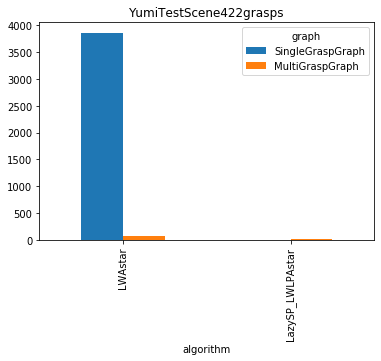

In [71]:
def plot_runtimes(data, scene, algorithms):
    plot_data = data[(data['scene'] == scene) & (data['algorithm'].isin(algorithms))]
    plot_data = plot_data.pivot(index='algorithm', columns='graph', values='runtime')
    plot_data = plot_data.fillna(0)
    plot_data['MultiGraspGraph'] = (plot_data['MultiGraspGraph'] + plot_data['LazyWeightedMultiGraspGraph']).astype("float")
    return plot_data[['SingleGraspGraph', 'MultiGraspGraph']].plot(kind='bar', title=scene)
# pd.DataFrame(bugtrap_data[bugtrap_data['graph'] == 'SingleGraspGraph']['runtime'], columns=bugtrap_data[bugtrap_data['graph'] == 'SingleGraspGraph']['algorithm'])
# plot = plot_runtimes(data, 'Bugtrap2DScene', ['Astar', 'LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'Standard2DScene', ['Astar', 'LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'YumiTestScene6grasps', ['LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'YumiTestScene20grasps', ['LWAstar', 'LazySP_LWLPAstar'])
# plot = plot_runtimes(data, 'YumiTestScene158grasps', ['LWAstar', 'LazySP_LWLPAstar'])
plot = plot_runtimes(data, 'YumiTestScene422grasps', ['LWAstar', 'LazySP_LWLPAstar'])
fig = plot.get_figure()
fig.savefig('/tmp/test.png', bbox_inches='tight')



In [7]:
# read all results in a folder
load_results('/tmp/placement_eval')


,algorithm,graph,runtime,runtime_std,base_validity_checks,grasp_validity_checks,base_edge_cost,grasp_edge_cost,base_expansions,grasp_expansions,roadmap_size,scene,num_grasps
0,LWAstar,SingleGraspGraph,0.438916,0.021709,623,710,0,589,0,514,10006,Standard2DScene,2
1,LWAstar,FoldedMultiGraspGraphDynamic,0.818320,0.063116,892,408,673,395,651,378,10006,Standard2DScene,2
2,LWAstar,FoldedMultiGraspGraphDynamic,0.109444,0.002362,102,102,12,2,3,2,1101,YumiTestScene,6
3,LWAstar,MultiGraspGraph,0.372321,0.045744,505,610,0,451,1,416,10006,Standard2DScene,2
4,LWAstar,SingleGraspGraph,282.793000,4.598705,1101,2454,0,11884,0,2116,1101,YumiTestScene,6
5,LWAstar,FoldedMultiGraspGraphStationary,1.461936,0.047954,1833,1038,673,967,651,926,10006,Standard2DScene,2
6,LWAstar,MultiGraspGraph,0.194319,0.002220,102,103,0,12,1,3,1101,YumiTestScene,6
7,LazySP_LWLPAstar,LazyWeightedMultiGraspGraph,4.060318,0.082785,584,80,555,64,1,33781,10006,Standard2DScene,2
8,LazySP_LWLPAstar,LazyWeightedMultiGraspGraph,0.239866,0.007013,102,102,12,2,1,15,1101,YumiTestScene,6
9,LWAstar,FoldedMultiGraspGraphStationary,0.122753,0.000987,102,102,12,3,3,3,1101,YumiTestScene,6


## Plotting results
This section defines some functions to plot results.